# Proyecto de Minería de Datos: Predicción de Precios de Vehículos

# Integrantes:

# Carlos Adrian Valencia Mendoza

#Joao Elian Moreira

#Steven Ernesto Magallanes Loor

# 1. Introducción y Objetivos
El mercado de automóviles de segunda mano es complejo debido a la gran cantidad de variables que afectan el precio final (kilometraje, año, combustible, tipo de vendedor).

El objetivo de este proyecto es entrenar un modelo de Aprendizaje Supervisado (Regresión) capaz de predecir el precio de venta de un auto basándose en sus características, aplicando metodología KDD (Knowledge Discovery in Databases).

Dataset: car_prediction_data.csv

Fuente: https://www.kaggle.com/datasets/muqaddasejaz/car-price-prediction-dataset

Tipo: Regresión

# 1.1 Carga y Descripción de los Datos

Primero, importamos las librerías necesarias para la manipulación de datos (pandas, numpy) y la visualización (matplotlib, seaborn). Posteriormente, cargamos el dataset para tener una primera vista de su estructura.

In [1]:
# Importación de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
df = pd.read_csv('/content/car_prediction_data.csv')
df.head()

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


# 2. Preprocesamiento: Limpieza y Nuevas Variables

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       301 non-null    object 
 1   Year           301 non-null    int64  
 2   Selling_Price  301 non-null    float64
 3   Present_Price  301 non-null    float64
 4   Kms_Driven     301 non-null    int64  
 5   Fuel_Type      301 non-null    object 
 6   Seller_Type    301 non-null    object 
 7   Transmission   301 non-null    object 
 8   Owner          301 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 21.3+ KB


In [4]:
df.isnull().sum()

,0
Car_Name,0
Year,0
Selling_Price,0
Present_Price,0
Kms_Driven,0
Fuel_Type,0
Seller_Type,0
Transmission,0
Owner,0


In [5]:
df.isna().sum()

,0
Car_Name,0
Year,0
Selling_Price,0
Present_Price,0
Kms_Driven,0
Fuel_Type,0
Seller_Type,0
Transmission,0
Owner,0


In [6]:
df.duplicated().sum()

np.int64(2)

Antes de limpiar, crearemos variables que aporten más valor al modelo.

Vehicle_Age: En lugar de usar el año de fabricación (Year), calculamos la antigüedad del auto, ya que la depreciación está ligada a la edad.

Kms_Per_Year: Nos ayuda a entender la intensidad de uso del vehículo.

Age_Squared: Representa la depreciación no lineal (un auto pierde valor mucho más rápido en sus primeros años).

In [7]:
# --- INGENIERÍA DE CARACTERÍSTICAS (Crear nuevas variables) ---
current_year = 2024 # Ajustamos al año actual o de referencia

# 1. Antigüedad: Calculamos cuántos años tiene el auto
df['Vehicle_Age'] = current_year - df['Year']

# 2. Desgaste Anual: ¿Cuántos km recorre por año? (Ayuda a detectar taxis o autos muy usados)
df['Kms_Per_Year'] = df['Kms_Driven'] / (df['Vehicle_Age'] + 1)

# 3. Depreciación: Los autos pierden valor más rápido al inicio (variable cuadrática)
df['Age_Squared'] = df['Vehicle_Age'] ** 2

## 2.1 Eliminación de Duplicados
Los datos duplicados pueden sesgar el modelo, dándole más peso a ciertos ejemplos repetidos. Procedemos a eliminarlos.

In [8]:
# --- LIMPIEZA DE DATOS ---
print(f"Filas originales: {df.shape[0]}")

# Eliminamos duplicados para no sesgar el modelo
df.drop_duplicates(inplace=True)

Filas originales: 301


# 2.2 Tratamiento de Outliers (Valores Atípicos)
Basándonos en un análisis del negocio, eliminamos registros que no representan el comportamiento normal del mercado:

Kilometraje excesivo: Autos con más de 500,000 km.

Precios extremos: Usamos el rango intercuartílico para filtrar autos excesivamente caros o baratos (probables errores o autos de colección que distorsionan la predicción).

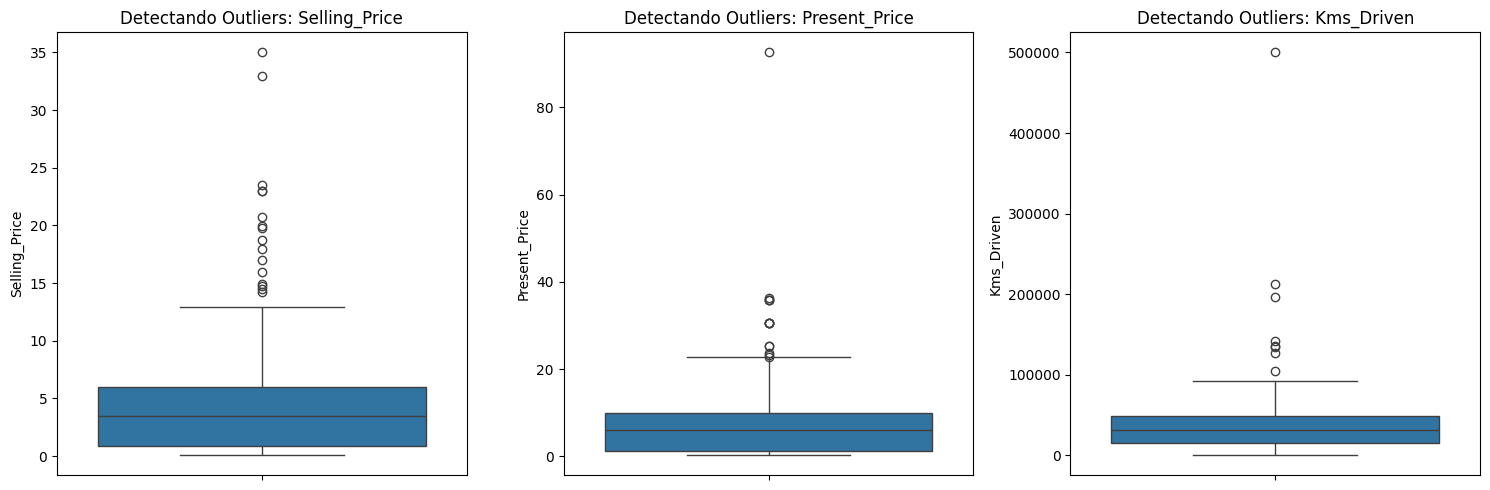

In [9]:
# Variables numéricas a analizar
cols_num = ['Selling_Price', 'Present_Price', 'Kms_Driven']

plt.figure(figsize=(15, 5))
for i, col in enumerate(cols_num):
    plt.subplot(1, 3, i+1)
    sns.boxplot(data=df, y=col)
    plt.title(f'Detectando Outliers: {col}')

plt.tight_layout()
plt.show()

In [10]:
# Filtramos Outliers (Valores extremos)
# Eliminamos autos con kilometrajes sospechosamente altos (> 500,000 km)
df = df[df['Kms_Driven'] < 500000]

# Eliminamos precios extremos usando rangos estadísticos (evitamos autos de súper lujo que confundan)
Q1 = df['Selling_Price'].quantile(0.05)
Q3 = df['Selling_Price'].quantile(0.95)
df = df[(df['Selling_Price'] >= Q1) & (df['Selling_Price'] <= Q3)]

print(f"Filas limpias para entrenar: {df.shape[0]}")

Filas limpias para entrenar: 272


# 3. Transformación de Datos
**¿Qué hacemos?**

Estandarizamos: Ponemos los números grandes (Kilometraje) y pequeños (Años) en la misma escala.

Codificamos: Convertimos texto (Gasolina, Diesel) en números (0, 1). ¿Por qué? Los algoritmos matemáticos no entienden palabras como "Diesel" ni manejan bien mezclas de números gigantes con pequeños. Transformar los datos facilita el aprendizaje.

In [11]:
# Variables numéricas que vamos a escalar
cols_to_scale = ['Present_Price', 'Kms_Driven', 'Vehicle_Age', 'Kms_Per_Year', 'Age_Squared']

# 1. Estandarización (Poner todo en la misma escala)
scaler = StandardScaler()
df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])

# 2. Codificación (Convertir texto a números)
# Convertimos Fuel_Type, Seller_Type, Transmission en columnas de 0s y 1s
df = pd.get_dummies(df, columns=['Fuel_Type', 'Seller_Type', 'Transmission'], drop_first=True)

# Eliminamos columnas que ya no sirven (Year ya lo convertimos en Age)
df.drop(['Year', 'Car_Name'], axis=1, inplace=True, errors='ignore')

# Verificamos cómo quedó la tabla final
df.head()

,Selling_Price,Present_Price,Kms_Driven,Owner,Vehicle_Age,Kms_Per_Year,Age_Squared,Fuel_Type_Diesel,Fuel_Type_Petrol,Seller_Type_Individual,Transmission_Manual
0,3.35,-0.172244,-0.260733,0,-0.092056,-0.224214,-0.188111,False,True,False,True
1,4.75,0.596966,0.317472,0,0.270832,0.389534,0.122166,True,False,False,True
2,7.25,0.657334,-0.987102,0,-1.180719,-1.089845,-0.941642,False,True,False,True
3,2.85,-0.452664,-1.048536,0,0.996607,-1.356852,0.831372,False,True,False,True
4,4.60,0.077019,0.297596,0,-0.092056,0.539470,-0.188111,True,False,False,True


# 4. Minería de Datos: Entrenamiento del Modelo
**¿Qué hacemos?**

Usamos el algoritmo Gradient Boosting Regressor. Configuramos una "búsqueda de rejilla" (GridSearch) que probará cientos de combinaciones de configuración. ¿Por qué? Gradient Boosting es un algoritmo potente que aprende de sus propios errores secuencialmente. Al usar GridSearch, nos aseguramos de no adivinar la configuración, sino de encontrar matemáticamente la mejor combinación para tus datos.

In [12]:
# Separamos X (variables predictoras) e y (variable objetivo)
X = df.drop('Selling_Price', axis=1)
y = df['Selling_Price']

# División 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Datos de entrenamiento: {X_train.shape}")
print(f"Datos de prueba: {X_test.shape}")

Datos de entrenamiento: (217, 10)
Datos de prueba: (55, 10)


**4.1 Selección y Entrenamiento del Algoritmo**

Utilizaremos Gradient Boosting Regressor. A diferencia de Random Forest, este algoritmo construye árboles secuencialmente, donde cada nuevo árbol corrige los errores del anterior.

Para asegurar el mejor rendimiento, usamos GridSearchCV para encontrar los hiperparámetros óptimos (n_estimators, learning_rate, max_depth).

In [13]:
# Definimos las opciones que el modelo va a probar
param_grid = {
    'n_estimators': [100, 200],      # Número de árboles de decisión
    'max_depth': [3, 5],             # Qué tan complejas son las decisiones
    'learning_rate': [0.05, 0.1],    # Qué tan rápido aprende (más lento suele ser más preciso)
    'subsample': [0.8, 1.0]          # Cuántos datos usa para cada árbol
}

print("Entrenando modelo (esto puede tardar unos segundos)...")

# Configuramos el modelo inteligente
gb_model = GradientBoostingRegressor(random_state=42)
grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid,
                           cv=5, scoring='r2', n_jobs=-1)

# ¡A entrenar!
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print(f"¡Listo! La mejor configuración fue: {grid_search.best_params_}")

Entrenando modelo (esto puede tardar unos segundos)...
¡Listo! La mejor configuración fue: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}


# 5. Evaluación de Resultados
**¿Qué hacemos?**

Calculamos el error del modelo y visualizamos qué tan cerca estuvieron las predicciones de la realidad. ¿Por qué? Necesitamos un número objetivo (R²) para saber si podemos confiar en este modelo antes de usarlo.

--- RESULTADOS FINALES ---
Precisión (R²): 0.9599 (Un valor cercano a 1.0 es excelente)
Error Promedio (MAE): 0.48 (En miles de moneda)


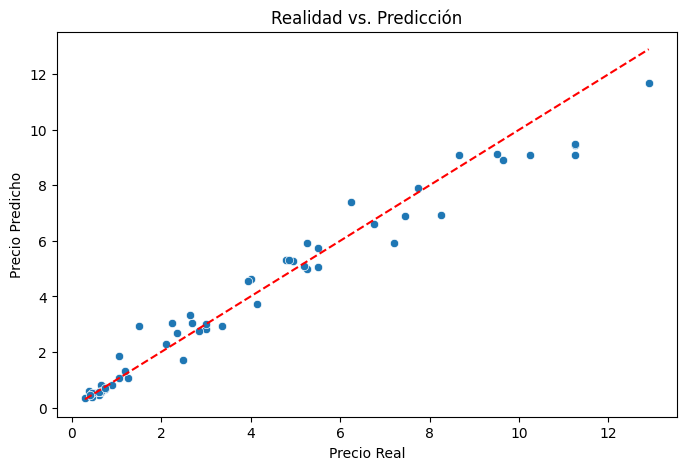

In [14]:
# Hacemos predicciones en el examen final (Test set)
y_pred = best_model.predict(X_test)

# Métricas de error
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"--- RESULTADOS FINALES ---")
print(f"Precisión (R²): {r2:.4f} (Un valor cercano a 1.0 es excelente)")
print(f"Error Promedio (MAE): {mae:.2f} (En miles de moneda)")

# Gráfico
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--') # Línea ideal
plt.xlabel('Precio Real')
plt.ylabel('Precio Predicho')
plt.title('Realidad vs. Predicción')
plt.show()

#Prueba del entrenamiento

In [15]:
# --- ZONA EDITABLE: Introduce aquí los datos de tu auto ---
nuevo_auto = {
    'Present_Price': 12000,    # Precio original de agencia (en miles)
    'Kms_Driven': 240000,       # Kilometraje actual
    'Fuel_Type': 'Petrol',    # Petrol, Diesel, o CNG
    'Seller_Type': 'Individual',  # Dealer o Individual
    'Transmission': 'Manual', # Manual o Automatic
    'Owner': 5,               # Número de dueños anteriores (0, 1, 3)
    'Year': 2015              # Año del auto
}
# ----------------------------------------------------------

# PROCESAMIENTO AUTOMÁTICO (No es necesario editar abajo)
# Convertimos tu diccionario en un formato que el modelo entienda
input_df = pd.DataFrame([nuevo_auto])

# 1. Calculamos las variables nuevas
input_df['Vehicle_Age'] = 2024 - input_df['Year']
input_df['Kms_Per_Year'] = input_df['Kms_Driven'] / (input_df['Vehicle_Age'] + 1)
input_df['Age_Squared'] = input_df['Vehicle_Age'] ** 2

# 2. Escalamos los números (usando el mismo escalador del entrenamiento)
cols_num = ['Present_Price', 'Kms_Driven', 'Vehicle_Age', 'Kms_Per_Year', 'Age_Squared']
input_df[cols_num] = scaler.transform(input_df[cols_num])

# 3. Preparamos las columnas categóricas (rellenamos con 0 las que faltan)
# Esto es necesario porque el modelo espera todas las columnas (Diesel, Petrol, etc.)
for col in X.columns:
    if col not in input_df.columns:
        # Lógica simple para one-hot encoding manual
        if col.startswith('Fuel_Type_') and nuevo_auto['Fuel_Type'] in col:
            input_df[col] = 1
        elif col.startswith('Seller_Type_') and nuevo_auto['Seller_Type'] in col:
            input_df[col] = 1
        elif col.startswith('Transmission_') and nuevo_auto['Transmission'] in col:
            input_df[col] = 1
        else:
            input_df[col] = 0

# Ordenamos las columnas igual que en el entrenamiento
input_df = input_df[X.columns]

# Predicción
precio_estimado = best_model.predict(input_df)[0]
print(f"💰 El precio estimado para este vehículo es: {precio_estimado:.2f}")

💰 El precio estimado para este vehículo es: 9.77
